# Mapping Encampment Service Requests, Park Amenities, and Transit

## Import the Libraries I will be using
1. Pandas
2. Plotly Express
3. Geopandas

In [1]:
import geopandas as gpd
import pandas as pd
import plotly.express as px
import folium

## Datasets
There are 6 datasets I will want to access
1. Park Amenities in LA County
2. Encampment Service Requests via 311 Calls in the City of LA
3. A City of LA Parks Shapefile
4. A City of LA Shapefile with Council Districts
5. Census Tracts Shapefile

Because 2020 is such an anomaly year, I'm actually going to use 2019 encampment request data for this initial investigation. I've invested a lot of time into cleaning it elsewhere, so I'll use a download instead of Socrata. The Park Amenities are sadly not hosted on Socrata so I'll use a download for that as well.

In [2]:
#bring in the data
#this is a bit more complicated for Census Tract Shapes to avoid missing 0 issue
parks=gpd.read_file('data/LA_Parks_Information.geojson')
encamp_19=gpd.read_file('data/2019-311_Homeless_Encampments_Requests-raw.csv')
resources=gpd.read_file('data/Countywide_Parks_and_Open_Space__Public_-_Hosted_.csv')
city=gpd.read_file('data/la-city-council-districts-2012.geojson')
bus = gpd.read_file('data/Bus Stop Shapefile 2/LineServingStops1219.dbf')
tract_shape=gpd.read_file('data/LA_tracts.geojson')

## Clean the Data
I'm going to clean these sets one by one, focusing on making everything lowercase, standardizing naming, and cutting down to just what I need.

### Park Shape Data

In [3]:
#looking at this, we have a few parks not really in LA
#LA has 15 council districts, so anything where cd_real=99 is elswhere
parks=parks.sort_values(by='cd_real',ascending = False)

#I'm going to create a dataframe without those 4 non-LA located parks
#to do this, I need to convert cd from string to integer to use it as a number
parks['cd_real'] = parks['cd_real'].astype(int)
parks_la=parks[parks['cd_real']<=16]
parks_la=parks_la.sort_values(by='cd_real',ascending = True)

#some of these columns are irrelevant or redundant
#this is already in lower case so I don't need to edit names
columns_to_drop = ['objectid',
                   'park_id',
                   'name_alpha',
                   'region',
                   'name_publi',
                   'park_class']
parks_la = parks_la.drop(columns_to_drop,axis=1)

#excellent. Let's learn a little about these parks.
#there appear to be 557 parks in the city of LA.
parks_la.info()

#the index is currently the park id. We can reset this.
parks_la.reset_index(inplace=True)
parks_la = parks_la.rename(columns = {'index':'park_id'})

#So given all that let's just be simple - add a freqency column
parks_la['freq'] = parks_la['cd_real'].map(parks_la['cd_real'].value_counts())
df_parks_cd=parks_la.groupby(['cd_real']).count()['freq']
df_parks_cd = df_parks_cd.reset_index()
df_parks_cd

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 557 entries, 471 to 454
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   name        557 non-null    object  
 1   shape_area  557 non-null    object  
 2   shape_leng  557 non-null    object  
 3   area_acres  557 non-null    object  
 4   issubpark   557 non-null    object  
 5   address     557 non-null    object  
 6   cd_real     557 non-null    int64   
 7   geometry    557 non-null    geometry
dtypes: geometry(1), int64(1), object(6)
memory usage: 39.2+ KB


cd_real  freq
0         1    49
1         2    33
2         3    21
3         4    41
4         5    28
5         6    28
6         7    38
7         8    26
8         9    34
9        10    24
10       11    50
11       12    47
12       13    35
13       14    54
14       15    49

In [4]:
#now graph and label! Including showing all CD #s.
chart=px.bar(df_parks_cd,
       x='cd_real',
       y='freq',
       title='Parks per LA City Council District',
       labels={'cd_real':"Council District",'freq':"Number of Parks"}
      )
chart.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 1
    )
)

### Encampment Report Data

In [5]:
#some of these columns are irrelevant or redundant
columns_to_drop = ['SRNumber',
                   'UpdatedDate',
                   'ActionTaken',
                   'Owner',
                   'RequestType',
                   'Status',
                   'RequestSource',
                   'Anonymous',
                   'AssignTo',
                   'ServiceDate',
                   'ClosedDate',
                   'Address',
                   'HouseNumber',
                   'Direction',
                   'StreetName',
                   'Suffix',
                   'ZipCode',
                   'Location',
                   'CreatedByUserOrganization',
                   'MobileOS',
                   'TBMPage',
                   'TBMColumn',
                   'TBMRow']
encamp_19 = encamp_19.drop(columns_to_drop,axis=1)

#rename in lower case
encamp_19.columns = ['created',
                     'loc_verified',
                     'approx_loc',
                     'lat',
                     'long',
                     'apc',
                     'cd',
                     'cd_member',
                     'nc',
                     'nc_name',
                     'precinct',
                     'geometry']

#Note that there is a column asking whether location is approximate
#how many were approximated?
#I also want a percentage so lets do some math
#Wow - a huge percentage of Service Requests used an approximate location.
#That will be important to remember.
df_approx_loc=encamp_19[encamp_19['approx_loc']=="N"]
print(str(len(df_approx_loc)) + ' of 44,583 Encampment Reports used an exact location')
print(str(100 - (len(df_approx_loc)/(len(encamp_19))*100)) + ' % of Encampment Reports used approximate or unverified locations')

#Now let's look at encampments per council district
#Learned my lesson last time - let's keep it simple for now
#So given all that let's just be simple - add a freqency column
encamp_19['freq'] = encamp_19['cd'].map(encamp_19['cd'].value_counts())
df_encamp_19_cd=encamp_19.groupby(['cd']).count()['freq']
df_encamp_19_cd = df_encamp_19_cd.reset_index()
df_encamp_19_cd

19909 of 44,583 Encampment Reports used an exact location
55.34396518852478 % of Encampment Reports used approximate or unverified locations


cd  freq
0    1  2558
1   10  3054
2   11  3626
3   12  1463
4   13  5279
5   14  4273
6   15  1220
7    2  3699
8    3  3076
9    4  4048
10   5  2585
11   6  3986
12   7  1583
13   8  1162
14   9  2971

In [6]:
#That checks out
#Let's graph
#Eventually I'll want to look at both parks and Encampment service requests
#per CD together - but for now I'm not joining that data.
chart2=px.bar(df_encamp_19_cd,
       x='cd',
       y='freq',
       title='Encampment Service Requests per LA City Council District',
       labels={'cd':"Council District",'freq':"Number of Parks"}
      )
chart2.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 1
    )
)

### Resources Data

In [7]:
#some of these columns are irrelevant or redundant
columns_to_drop = ['OBJECTID',
                   'RPT_ACRES',
                   'UNIT_ID',
                   'LMS_ID',
                   'PARK_LBL',
                   'GIS_ACRES',
                   'AGNCY_NAME',
                   'ZIP','HOURS',
                   'DGPRK',
                   'GYM',
                   'PHONES',
                   'IS_COUNTY',
                   'PLGND',
                   'POOLS',
                   'Shape__Area',
                   'Shape__Length',
                   'FITZN',
                   'MPFLD',
                   'ADDRESS',
                   'CITY',
                   'SK8PK',
                   'TENIS',
                   'BSKTB',
                   'BASEB',
                   'MPFLD',
                   'SOCCR',
                   'TOTAL_GOOD',
                   'AGNCY_TYP',
                   'AGNCY_LEV',
                   'AGNCY_WEB',
                   'TKIT_SUM',
                   'PRKINF_CND',
                   'AM_TRLS',
                   'TRLS_MI',
                   'SPPAD',
                   'MNG_AGENCY',
                   'NDS_AN_TYP',
                   'NEEDS_ANLZ',
                   'SNRCT',
                   'AMEN_RPT',
                   'COMCT',
                   'AM_OPNSP',
                   'TOTAL_FAIR',
                   'TYPE',
                   'TOTAL_POOR']
resources = resources.drop(columns_to_drop,axis=1)

#rename in lower case
#and we are all clean!
resources.columns = ['name',
                     'access',
                     'type',
                     'picnic',
                     'restroom',
                     'center_lat',
                     'center_long',
                     'geometry']
resources.head()

name       access                     type  \
0                        El Barrio Park  Open Access              Pocket Park   
1                        El Dorado Park  Open Access        Neighborhood Park   
2                  Atlantic Avenue Park  Open Access                   Pocket   
3                     El Escorpion Park  Open Access  Community Regional Park   
4  El Marino Park/ El Marino Elementary  Open Access              Pocket Park   

  picnic restroom   center_lat    center_long geometry  
0      0        1  34.09708079  -117.70442319     None  
1      0        1  34.69157769  -118.12210927     None  
2      2        1  34.02530363  -118.15520092     None  
3      0        0  34.19674178   -118.6641685     None  
4      2        0  33.99251602   -118.3992332     None

### Census Tract Shape

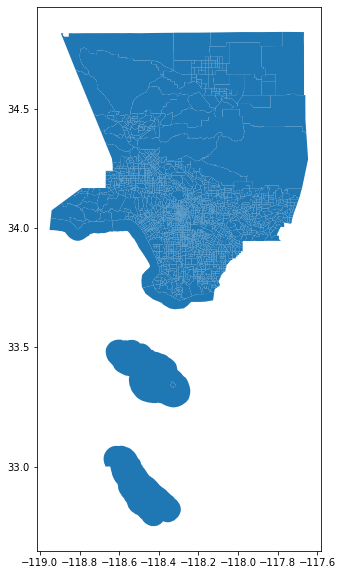

In [8]:
#cut down to what we need - FIPS and gemetry
tract_shape = tract_shape[['name','geometry']]

#rename name column so we don't get confused
tract_shape.columns = ['FIPS','geometry']

#plot census tracts
tract_shape.plot(figsize=(12,10))

### Metro Bus Stops Data

stop_num  line dir                   stop_name        lat        long  \
0         1   108   E         PARAMOUNT / SLAUSON  33.973248 -118.113113   
1         1   265   S         PARAMOUNT / SLAUSON  33.973248 -118.113113   
2         3    35   N            JEFFERSON / 10TH  34.025471 -118.328402   
3         6    55   N  120TH \ AUGUSTUS F HAWKINS  33.924696 -118.242222   
4         6   120   W  120TH \ AUGUSTUS F HAWKINS  33.924696 -118.242222   

                      geometry  
0  POINT (-118.11311 33.97325)  
1  POINT (-118.11311 33.97325)  
2  POINT (-118.32840 34.02547)  
3  POINT (-118.24222 33.92470)  
4  POINT (-118.24222 33.92470)

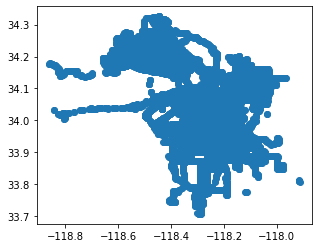

In [9]:
#now let's check out our bus stops
#rename columns
bus.columns = ['stop_num',
 'line',
 'dir',
 'stop_name',
 'lat',
 'long',
 'geometry']

#ensure projection matches other data and check plot
#I can't tell if some of these go out of city limits
#will have to look closer when I start mapping with overlays.
bus=bus.set_crs("EPSG:4326")
bus.crs
bus.plot()
bus.head()

## Adding Geometry to data for plotting

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

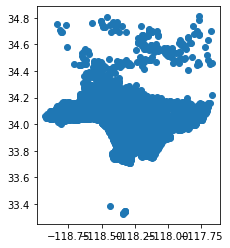

In [10]:
#Now I need to give these parks some geometries to make them mappable
#and eventually able to merge with park shape
g_resources = gpd.GeoDataFrame(
    resources, geometry=gpd.points_from_xy(resources.center_long, resources.center_lat))
resources.plot() 
resources=resources.set_crs("EPSG:4326")
resources.crs

## Narrowing data to desired area

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

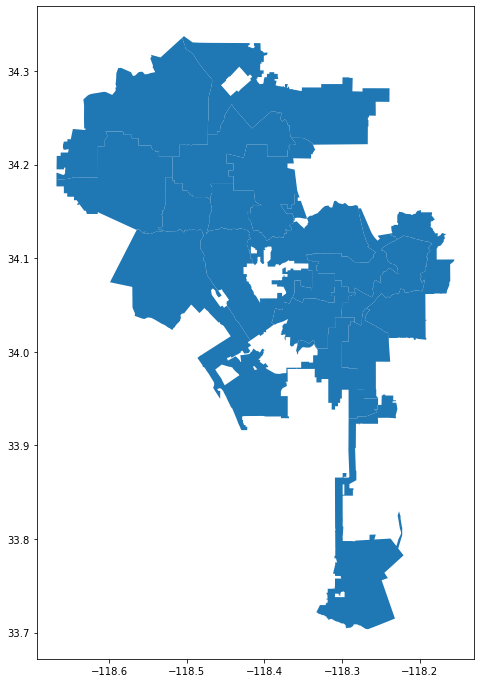

In [11]:
#that worked. Now I need to only include resources within City of LA boundaries.
city.plot(
            figsize=(20,12),
) 
city=city.set_crs("EPSG:4326")
city.crs

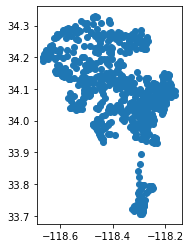

In [12]:
#then use a spatial join to just get the resources within the city area
la_resources = gpd.sjoin(resources, city)
la_resources.plot()

In [13]:
#excellent. but there are some redundancies/unnecessary info again
#lets clean up with data once more
columns_to_drop = ['center_lat',
                   'center_long',
                   'index_right',
                   'kind',
                   'external_id',
                   'name_right',
                   'slug',
                   'set',
                   'metadata',
                   'resource_uri']
la_resources = la_resources.drop(columns_to_drop,axis=1)
la_resources.columns = ['name',
                     'access',
                     'type',
                     'picnic',
                     'restroom',
                     'geometry']
la_resources.head()

name       access                     type picnic  \
3         El Escorpion Park  Open Access  Community Regional Park      0   
33       Garden of the Gods  Open Access             Not Analyzed      0   
34  Garden of the Gods Park  Open Access  Community Regional Park      0   
50      Gothic Rinaldi Park  Open Access             Not Analyzed      0   
51       Granada Hills Park  Open Access           Community Park      1   

   restroom                     geometry  
3         0  POINT (-118.66417 34.19674)  
33        0  POINT (-118.61100 34.27324)  
34        0  POINT (-118.60171 34.27451)  
50        0  POINT (-118.48131 34.27801)  
51        1  POINT (-118.49679 34.26288)

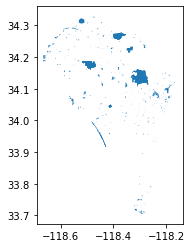

In [14]:
#now let's join these to our park shapefile
park_info = gpd.sjoin(parks_la, la_resources)
park_info.plot()

## Introductory Analysis - Parks

(-118.69379615000001, -118.12964684999997, 33.6719924, 34.3689876)

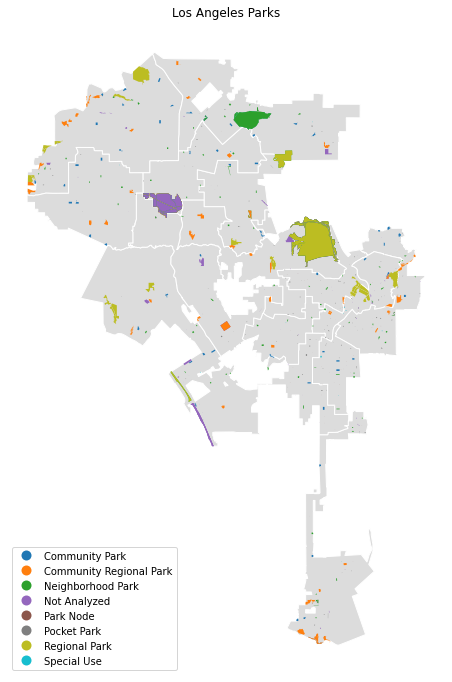

In [15]:
#first let's look at all parks in context
#we'll need a base map to make sense of anything
base=city.plot(figsize=(12,12),color='gainsboro', 
                               edgecolor='white')

ax3 = park_info.plot(ax=base, 
                     column='type',
                     legend=True,
                     legend_kwds={'loc':'lower left'})

# add a title
ax3.set_title('Los Angeles Parks')

# get rid of the axis
ax3.axis('off')

In [17]:
#excellent. again, let's keep it clean.
columns_to_drop = ['park_id',
                   'index_right',
                    'name_right',
                    'shape_leng']
park_info = park_info.drop(columns_to_drop,axis=1)
park_info.columns = ['name',
                     'park_area',
                     'park_acres',
                     'issubpark',
                     'address',
                     'cd',
                     'geometry',
                     'parks_in_cd',
                     'access',
                     'type',
                     'picnic',
                     'restroom'
                       ]

#note the "is subpark" category
#are many parks subparks?
chart=px.bar(park_info,
       x='issubpark',
       labels={'type':"Park Type",'count':"Number of Parks"},
       title='Los Angeles Park Types',
       barmode='group'
      )
chart.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 1
    )
)
chart.update_traces(marker_line_width=0) # get rid of white lines
park_info.head()

name      park_area      park_acres issubpark  \
0        Vista Hermosa Soccer Field  81856.4316403   1.87917261403         N   
1       Ernest E Debs Regional Park  13879064.2613   318.620747882         N   
2  Cleland Avenue Bicentennial Park  40077.2540351  0.920050834356         N   
3               Sycamore Grove Park  691462.199493   15.8738513625         N   
5       Normandie Recreation Center  142508.174306   3.27155060469         N   

                          address  cd  \
0         1301 W 1st St, LA 90026   1   
1    4235 N Monterey Rd, LA 90032   1   
2    4800 E Cleland Ave, LA 90042   1   
3    4702 N Figueroa St, LA 90042   1   
5  1550 S Normandie Ave, LA 90006   1   

                                            geometry  parks_in_cd  \
0  MULTIPOLYGON (((-118.25717 34.06159, -118.2569...           49   
1  MULTIPOLYGON (((-118.18803 34.10388, -118.1879...           49   
2  MULTIPOLYGON (((-118.21178 34.11341, -118.2118...           49   
3  MULTIPOLYGON (((-118.20110 34.10134, -118.2011...           49   
5  MULTIPOLYGON (((-118.30014 34.04536, -118.2992...           49   

        access               type picnic restroom  
0  Open Access        Special Use      0        1  
1  Open Access      Regional Park      2        4  
2  Open Access        Pocket Park      0        0  
3  Open Access     Community Park      1        1  
5  Open Access  Neighborhood Park      0        0

In [18]:
#we want to avoid overlapping geometries where possible
#so it makes sense to eliminate subparks
park_info=park_info[park_info['issubpark']=="N"]
park_info.describe

<bound method NDFrame.describe of                                  name      park_area      park_acres  \
0          Vista Hermosa Soccer Field  81856.4316403   1.87917261403   
1         Ernest E Debs Regional Park  13879064.2613   318.620747882   
2    Cleland Avenue Bicentennial Park  40077.2540351  0.920050834356   
3                 Sycamore Grove Park  691462.199493   15.8738513625   
5         Normandie Recreation Center  142508.174306   3.27155060469   
..                                ...            ...             ...   
551          Grape Street Pocket Park  5203.85467587   0.11946454296   
552              San Pedro Plaza Park  152749.805211   3.50666703884   
553                         Alma Park  98617.0939395    2.2639460149   
554                         Peck Park  3246101.37868   74.5205317523   
556       Los Angeles Maritime Museum  107971.798241   2.47870133447   

    issubpark                                            address  cd  \
0           N                

In [19]:
#what types of parks are common?
chart=px.bar(park_info,
       x='type',
       labels={'type':"Park Type",'count':"Number of Parks"},
       title='Los Angeles Park Types',
       barmode='group'
      )
chart.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 1
    )
)
chart.update_traces(marker_line_width=0) # get rid of white lines

## Identifying Encampments by Census Tract

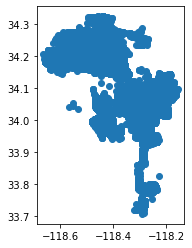

In [20]:
#first add geometry to encampments
g_encamp_19 = gpd.GeoDataFrame(
    encamp_19, geometry=gpd.points_from_xy(encamp_19.long, encamp_19.lat))

#then match crs
encamp_19=encamp_19.set_crs("EPSG:4326")
encamp_19.crs
encamp_19.plot() 

In [21]:
#now I want to merge encampment reports with census tract shapes
#This duplicates parks to reflect the # encampments reported within
tract_encamp = gpd.sjoin(tract_shape, encamp_19)
tract_encamp['freq'] = tract_encamp['FIPS'].map(tract_encamp['FIPS'].value_counts())
tract_encamp.head()

FIPS                                           geometry  \
0  06037101110  MULTIPOLYGON (((-118.30229 34.25870, -118.3007...   
0  06037101110  MULTIPOLYGON (((-118.30229 34.25870, -118.3007...   
0  06037101110  MULTIPOLYGON (((-118.30229 34.25870, -118.3007...   
0  06037101110  MULTIPOLYGON (((-118.30229 34.25870, -118.3007...   
0  06037101110  MULTIPOLYGON (((-118.30229 34.25870, -118.3007...   

   index_right          created loc_verified approx_loc          lat  \
0        43228  6/10/2019 22:02            Y          N  34.25969981   
0        43071   4/10/2019 8:15            Y          N   34.2575196   
0        43070   4/10/2019 7:59            Y          N   34.2575196   
0        43111  4/16/2019 19:11            Y             34.25775598   
0        43110  4/14/2019 13:40            Y             34.25775598   

           long               apc cd         cd_member  nc  \
0  -118.2912544  North Valley APC  7  Monica Rodriguez  10   
0  -118.2998249  North Valley APC  7  Monica Rodriguez  10   
0  -118.2998249  North Valley APC  7  Monica Rodriguez  10   
0  -118.3011203  North Valley APC  7  Monica Rodriguez  10   
0  -118.3011203  North Valley APC  7  Monica Rodriguez  10   

              nc_name  precinct  freq  
0  SUNLAND-TUJUNGA NC  FOOTHILL     7  
0  SUNLAND-TUJUNGA NC  FOOTHILL     7  
0  SUNLAND-TUJUNGA NC  FOOTHILL     7  
0  SUNLAND-TUJUNGA NC  FOOTHILL     7  
0  SUNLAND-TUJUNGA NC  FOOTHILL     7

In [22]:
#now dissolve to get rid of the endless repeats
tract_encamp_diss = tract_encamp.dissolve(by='FIPS')
tract_encamp_diss = tract_encamp_diss.reset_index()

(-118.69379615000001, -118.12964684999997, 33.6719924, 34.3689876)

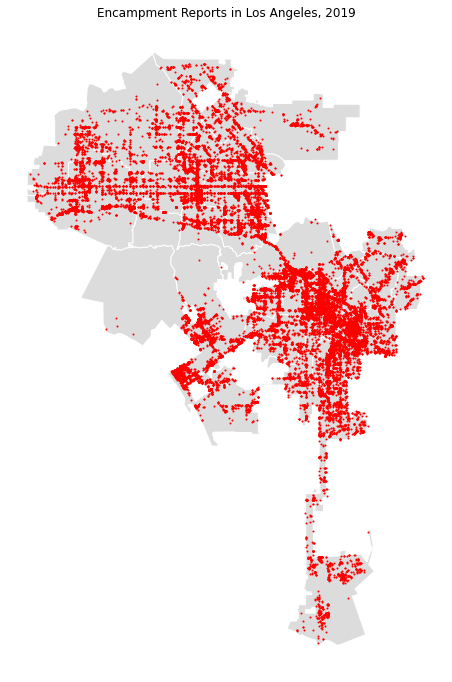

In [23]:
#first let's look at all encampment reports
#we'll need a base map to make sense of anything
base=city.plot(figsize=(12,12),color='gainsboro', edgecolor='white')
ax = encamp_19.plot(ax=base, color='red', markersize=1)

# add a title
ax.set_title('Encampment Reports in Los Angeles, 2019')

# get rid of the axis
ax.axis('off')

(-118.69380655, -118.12964844999999, 33.66468695, 34.373880050000004)

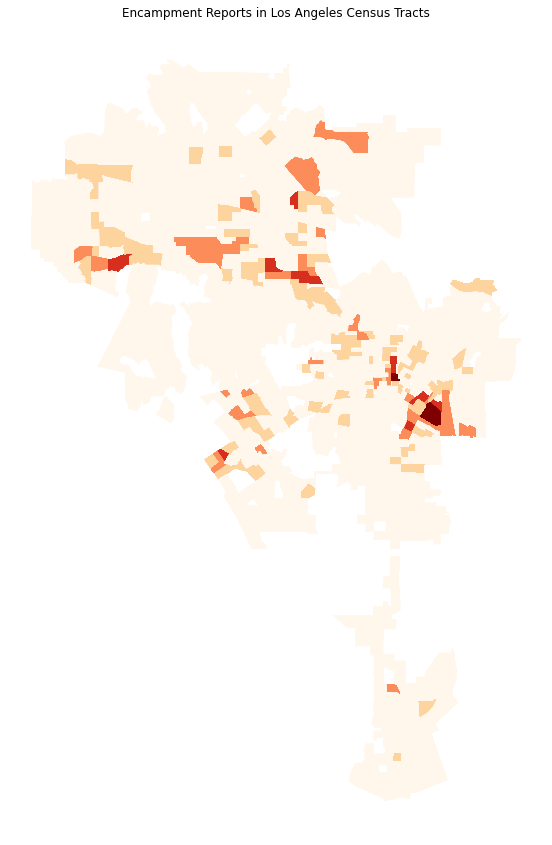

In [24]:
#then, we can look by census tracts
ax1 = tract_encamp.plot(figsize=(20,15),
                 column='freq',
                 legend=False, 
                 cmap="OrRd",
                 scheme='NaturalBreaks',
                 legend_kwds={'loc':'lower left'})

ax1.set_title('Encampment Reports in Los Angeles Census Tracts')

ax1.axis('off')

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:572: UserWarning:

Only specify one of 'column' or 'color'. Using 'color'.



(-118.69380655, -118.12964844999999, 33.66468695, 34.373880050000004)

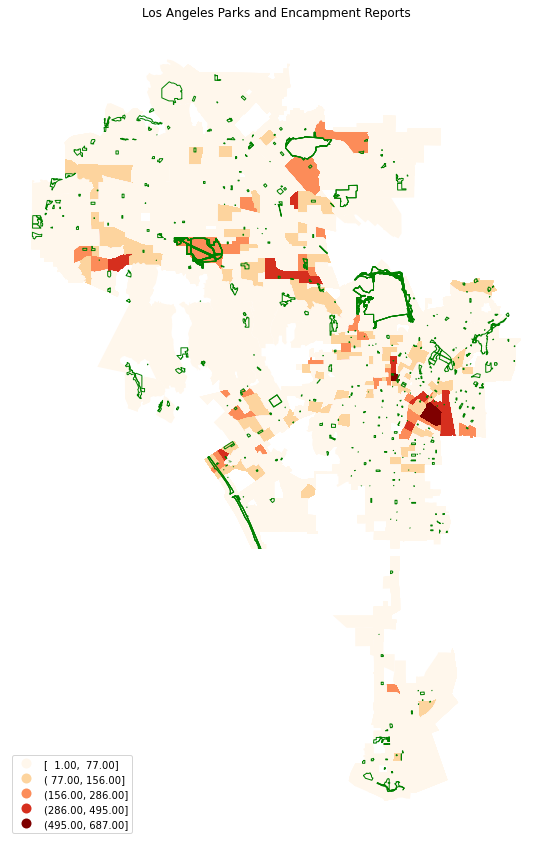

In [25]:
#then we can overlay the parks
base = tract_encamp.plot(figsize=(20,15),
                 column='freq',
                 legend=True, 
                 cmap="OrRd",
                 scheme='NaturalBreaks',
                 legend_kwds={'loc':'lower left'})

ax2=park_info.plot(ax=base,
                 color='none', 
                 edgecolor='green',            
                 column='freq',
                 legend=False 
                            );
ax2.set_title('Los Angeles Parks and Encampment Reports')

ax2.axis('off')

Now we see tracts where encampments were reported in the City of LA.

Some things stand out: Downtown and the Sepulveda Basin are not surprising given Skid Row and the number of fires in Sepulveda Basin. However, the Lakeview Terrace, Chatsworth Resevoir, and Eagle Rock areas are less expected.

In [26]:
#since we have been using council district info elsewhere
#may be helpful to see here 
#join encampment data with CD data
cd_encamp = gpd.sjoin(city, encamp_19)
cd_encamp['freq'] = cd_encamp['name'].map(cd_encamp['name'].value_counts())

In [27]:
#now dissolve to get rid of the endless repeats
cd_encamp = cd_encamp.dissolve(by='name')
cd_encamp = cd_encamp.reset_index()

(-118.69379615, -118.12964685, 33.6719924, 34.3689876)

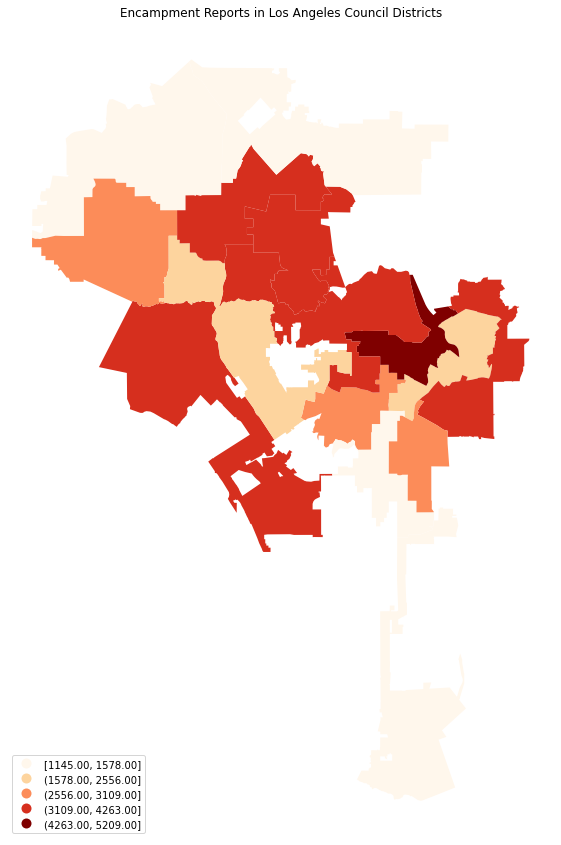

In [28]:
#and plot by council district
ax1 = cd_encamp.plot(figsize=(20,15),
                 column='freq',
                 legend=True, 
                 cmap="OrRd",
                 scheme='NaturalBreaks',
                 legend_kwds={'loc':'lower left'})

# add a title
ax1.set_title('Encampment Reports in Los Angeles Council Districts')

# get rid of the axis
ax1.axis('off')

## Identify Encampments in Parks

In [29]:
#now we have park name, address, council district, type, access, and restrooms
#in one dataframe
#now I want to merge encampment reports with park shapes and information
#This duplicates parks to reflect the # encampments reported within
park_encamp_ex = gpd.sjoin(park_info, encamp_19)
park_encamp_ex.head()

name      park_area     park_acres issubpark  \
1  Ernest E Debs Regional Park  13879064.2613  318.620747882         N   
1  Ernest E Debs Regional Park  13879064.2613  318.620747882         N   
1  Ernest E Debs Regional Park  13879064.2613  318.620747882         N   
1  Ernest E Debs Regional Park  13879064.2613  318.620747882         N   
1  Ernest E Debs Regional Park  13879064.2613  318.620747882         N   

                        address  cd_left  \
1  4235 N Monterey Rd, LA 90032        1   
1  4235 N Monterey Rd, LA 90032        1   
1  4235 N Monterey Rd, LA 90032        1   
1  4235 N Monterey Rd, LA 90032        1   
1  4235 N Monterey Rd, LA 90032        1   

                                            geometry  parks_in_cd  \
1  MULTIPOLYGON (((-118.18803 34.10388, -118.1879...           49   
1  MULTIPOLYGON (((-118.18803 34.10388, -118.1879...           49   
1  MULTIPOLYGON (((-118.18803 34.10388, -118.1879...           49   
1  MULTIPOLYGON (((-118.18803 34.10388, -118.1879...           49   
1  MULTIPOLYGON (((-118.18803 34.10388, -118.1879...           49   

        access           type  ... approx_loc          lat          long  \
1  Open Access  Regional Park  ...          Y   34.1016906  -118.1978547   
1  Open Access  Regional Park  ...              34.1016906  -118.1978547   
1  Open Access  Regional Park  ...          N  34.10381412  -118.1908148   
1  Open Access  Regional Park  ...          N  34.09757812  -118.2014555   
1  Open Access  Regional Park  ...          N  34.09757812  -118.2014555   

                    apc cd_right        cd_member  nc  \
1  East Los Angeles APC        1  Gilbert Cedillo  42   
1  East Los Angeles APC        1  Gilbert Cedillo  42   
1  East Los Angeles APC        1  Gilbert Cedillo  41   
1  East Los Angeles APC        1  Gilbert Cedillo  42   
1  East Los Angeles APC        1  Gilbert Cedillo  42   

                     nc_name    precinct  freq  
1             ARROYO SECO NC  HOLLENBECK  2558  
1             ARROYO SECO NC  HOLLENBECK  2558  
1  HISTORIC HIGHLAND PARK NC  HOLLENBECK  2558  
1             ARROYO SECO NC  HOLLENBECK  2558  
1             ARROYO SECO NC  HOLLENBECK  2558  

[5 rows x 25 columns]

In [30]:
#that duplication doesn't help us, so let's add frequency
park_encamp_ex['freq'] = park_encamp_ex['name'].map(park_encamp_ex['name'].value_counts())

In [31]:
#and dissolve, so that we only have 1 row per park
park_encamp_dissex = park_encamp_ex.dissolve(by='name')

In [32]:
#we also need to reset the index, and sort by something that will show us this worked
park_encamp_dissex = park_encamp_dissex.reset_index()
park_encamp_dissex=park_encamp_dissex.sort_values(by='name',ascending = True)
park_encamp_dissex

name  \
0                                  Angels Gate Park   
1                                  Arroyo Seco Park   
2                                    Barnsdall Park   
3   Benny H Potter West Adams Avenues Memorial Park   
4                                        Brand Park   
..                                              ...   
94                                     Wilacre Park   
95                       Winnetka Recreation Center   
96                                  Woodbridge Park   
97                            York Blvd Pocket Park   
98                       Yosemite Recreation Center   

                                             geometry      park_area  \
0   POLYGON ((-118.29271 33.71301, -118.29270 33.7...  3068532.21578   
1   MULTIPOLYGON (((-118.18504 34.10551, -118.1851...  3792749.70542   
2   POLYGON ((-118.29298 34.09930, -118.29298 34.0...  635668.513242   
3   POLYGON ((-118.31946 34.03445, -118.31994 34.0...  70645.0386299   
4   POLYGON ((-118.45569 34.27260, -118.45563 34.2...  771453.397194   
..                                                ...            ...   
94  POLYGON ((-118.40317 34.13826, -118.40316 34.1...  5450855.53773   
95  POLYGON ((-118.57120 34.22175, -118.57120 34.2...  694684.703837   
96  POLYGON ((-118.37460 34.14856, -118.37460 34.1...  205047.436648   
97  POLYGON ((-118.20707 34.12131, -118.20714 34.1...  12788.6660416   
98  POLYGON ((-118.20766 34.13050, -118.20833 34.1...  435735.894754   

        park_acres issubpark  \
0    70.4440883827         N   
1    87.0699007453         N   
2    14.5929994473         N   
3    1.62179341623         N   
4     17.747597775         N   
..             ...       ...   
94   125.134925189         N   
95   15.9478301787         N   
96   4.70726025805         N   
97  0.293588549046         N   
98   10.0031597269         N   

                                              address  cd_left  parks_in_cd  \
0                   3601 S Gaffey St, San Pedro 90731       15           49   
1                        5568 E Via Marisol, LA 90042       14           54   
2                     4800 W Hollywood Blvd, LA 90027       13           35   
3                            2413 S 2nd Ave, LA 90018       10           24   
4   15174 W San Fernando Mission Rd, Mission Hills...        7           38   
..                                                ...      ...          ...   
94  S of Maxwell Fire Rd; 12601 Mulholland Dr, Stu...        2           33   
95                8401 N Winnetka Ave, Winnetka 91306        3           21   
96             11240 W Moorpark St, Studio City 91602        2           33   
97                    4948-4956 E York Blvd, LA 90042       14           54   
98                       1840 W Yosemite Dr, LA 90041       14           54   

         access                     type  ... approx_loc          lat  \
0   Open Access  Community Regional Park  ...          N  33.71148326   
1   Open Access  Community Regional Park  ...             34.11061526   
2   Open Access           Community Park  ...             34.10151695   
3   Open Access              Pocket Park  ...             34.03457994   
4   Open Access           Community Park  ...             34.27207928   
..          ...                      ...  ...        ...          ...   
94  Open Access            Regional Park  ...          N  34.13345206   
95  Open Access           Community Park  ...             34.22139302   
96  Open Access        Neighborhood Park  ...             34.15018104   
97  Open Access              Pocket Park  ...             34.12132717   
98  Open Access           Community Park  ...             34.13344093   

            long                    apc cd_right           cd_member   nc  \
0   -118.2930027             Harbor APC       15        Joe Buscaino   96   
1   -118.1802165   East Los Angeles APC       14         Jose Huizar   41   
2   -118.2944837            Central APC       13     Mitch O'Farrell   36   
3 

In [33]:
#it's important to think back to the encampment data
#Over 44% of encampment addresses were estimated
#Especially since parks can be hard to find an address for
#Let's create a 1/2 block radius buffer
park_info['geometry']=park_info.geometry.buffer(.001)

#and create another spatial join to reflect the buffering
park_encamp = gpd.sjoin(park_info, encamp_19)
park_encamp.head()

<ipython-input-33-e6e7c3144c35>:5: UserWarning:

Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




name      park_area     park_acres issubpark  \
0   Vista Hermosa Soccer Field  81856.4316403  1.87917261403         N   
1  Ernest E Debs Regional Park  13879064.2613  318.620747882         N   
1  Ernest E Debs Regional Park  13879064.2613  318.620747882         N   
1  Ernest E Debs Regional Park  13879064.2613  318.620747882         N   
3          Sycamore Grove Park  691462.199493  15.8738513625         N   

                        address  cd_left  \
0       1301 W 1st St, LA 90026        1   
1  4235 N Monterey Rd, LA 90032        1   
1  4235 N Monterey Rd, LA 90032        1   
1  4235 N Monterey Rd, LA 90032        1   
3  4702 N Figueroa St, LA 90042        1   

                                            geometry  parks_in_cd  \
0  POLYGON ((-118.25821 34.06040, -118.25828 34.0...           49   
1  POLYGON ((-118.20267 34.09942, -118.20267 34.0...           49   
1  POLYGON ((-118.20267 34.09942, -118.20267 34.0...           49   
1  POLYGON ((-118.20267 34.09942, -118.20267 34.0...           49   
3  POLYGON ((-118.20579 34.09726, -118.20581 34.0...           49   

        access            type  ... approx_loc          lat          long  \
0  Open Access     Special Use  ...          N  34.06169109  -118.2584893   
1  Open Access   Regional Park  ...          Y   34.1016906  -118.1978547   
1  Open Access   Regional Park  ...              34.1016906  -118.1978547   
1  Open Access   Regional Park  ...             34.10171405  -118.2013037   
3  Open Access  Community Park  ...             34.10171405  -118.2013037   

                    apc cd_right        cd_member  nc  \
0           Central APC        1  Gilbert Cedillo  44   
1  East Los Angeles APC        1  Gilbert Cedillo  42   
1  East Los Angeles APC        1  Gilbert Cedillo  42   
1  East Los Angeles APC        1  Gilbert Cedillo  41   
3  East Los Angeles APC        1  Gilbert Cedillo  41   

                        nc_name    precinct  freq  
0  GREATER ECHO PARK ELYSIAN NC     RAMPART  2558  
1                ARROYO SECO NC  HOLLENBECK  2558  
1                ARROYO SECO NC  HOLLENBECK  2558  
1     HISTORIC HIGHLAND PARK NC   NORTHEAST  2558  
3     HISTORIC HIGHLAND PARK NC   NORTHEAST  2558  

[5 rows x 25 columns]

In [34]:
#and as before, adjust the spatial join for the buffered parks
#that duplication doesn't help us, so let's add frequency
park_encamp['freq'] = park_encamp['name'].map(park_encamp['name'].value_counts())

#and dissolve, so that we only have 1 row per park
park_encamp_diss = park_encamp.dissolve(by='name')

#we also need to reset the index, and sort by something that will show us this worked
park_encamp_diss = park_encamp_diss.reset_index()
park_encamp_diss=park_encamp_diss.sort_values(by='name',ascending = True)
park_encamp_diss

name  \
0      1st And Broadway Civic Center Park (TBD)   
1                       49th Street Pocket Park   
2                      6th & Gladys Street Park   
3                       76th Street Pocket Park   
4    Albert Piantanida Intergenerational Center   
..                                          ...   
271                             Woodbridge Park   
272            Woodland Hills Recreation Center   
273                           Woodside Triangle   
274                       York Blvd Pocket Park   
275                  Yosemite Recreation Center   

                                              geometry      park_area  \
0    POLYGON ((-118.24549 34.05495, -118.24542 34.0...   85532.956018   
1    POLYGON ((-118.26344 33.99957, -118.26334 33.9...  8250.43763411   
2    POLYGON ((-118.24165 34.03942, -118.24170 34.0...   14823.490385   
3    POLYGON ((-118.28833 33.96982, -118.28843 33.9...  5591.97634123   
4    POLYGON ((-118.44815 34.24514, -118.44805 34.2...  115992.665239   
..                                                 ...            ...   
271  POLYGON ((-118.37770 34.14885, -118.37770 34.1...  205047.436648   
272  POLYGON ((-118.61386 34.17465, -118.61438 34.1...  817168.061747   
273  POLYGON ((-118.20650 34.09950, -118.20641 34.0...   7562.9668937   
274  POLYGON ((-118.20610 34.12106, -118.20611 34.1...  12788.6660416   
275  POLYGON ((-118.20752 34.12951, -118.20819 34.1...  435735.894754   

         park_acres issubpark                                    address  \
0     1.96357433772         N                     217 W 1st St, LA 90012   
1    0.189404743709         N                    670 E 49Th St, LA 90011   
2    0.340301875096         N                 624 E 6th Street, LA 90021   
3    0.128374626015         N                    833 W 76th St, LA 90044   
4     2.66283584046         N  9540 N Van Nuys Blvd, Panorama City 91402   
..              ...       ...                                        ...   
271   4.70726025805         N     11240 W Moorpark St, Studio City 91602   
272   18.7596724157         N     5858 N Shoup Ave, Woodland Hills 91367   
273  0.173622524005         N                  Woodside Dr & Marmion Way   
274  0.293588549046         N            4948-4956 E York Blvd, LA 90042   
275   10.0031597269         N               1840 W Yosemite Dr, LA 90041   

     cd_left  parks_in_cd             access               type  ...  \
0         14           54        Open Access        Pocket Park  ...   
1          9           34        Open Access          Park Node  ...   
2         14           54        Open Access        Pocket Park  ...   
3          8           26        Open Access          Park Node  ...   
4          6           28  Restricted Access        Pocket Park  ...   
..       ...          ...                ...                ...  ...   
271        2           33        Open Access  Neighborhood Park  ...   
272        3           21        Open Access     Community Park  ...   
273        1           49        Open Access       Not Analyzed  ...   
274       14           54        Open Access        Pocket Park  ...   
275       14           54        Open Access     Community Park  ...   

    approx_loc          lat          long                    apc cd_right  \
0            N  34.05292846  -118.2444975            Central APC       14   
1            N   33.9984056  -118.2645197  South Los Angeles APC        9   
2            N  34.04004454  -118.2421345            Central APC       14   
3            N  33.97051712  -118.2880114  South Los Angeles APC        8   
4               34.24265591  -118.4502828       North Valley APC        6   
..         ...          ...           ...                    ...      ...   
271             34.15018104  -118.3765292       South Valley APC        2   
272             34.17471315  -118.6127447       South Valley APC        3   
273          N  34.09815761  -118.2054158   East Los Angeles APC        1   
274  

In [35]:
#some columns are not accurate anymore
#like encampment details, since we dissolved
#time to clean some more!
columns_to_drop = ['cd_left',
                   'index_right',
                   'created',
                    'loc_verified',
                    'approx_loc',
                    'lat',
                    'long',
                    'apc'
                        ]
park_encamp_diss = park_encamp_diss.drop(columns_to_drop,axis=1)
park_encamp_diss.columns = ['name',
                     'geometry',
                     'park_area',
                     'park_acres',
                     'issubpark',
                     'address',
                     'parks_in_cd',
                     'access',
                     'type',
                     'picnic',
                     'restroom',
                     'cd',
                     'cd_member',
                     'nc',
                     'nc_name',
                     'precinct',
                     'freq'
                       ]
park_encamp_diss.head()

name  \
0    1st And Broadway Civic Center Park (TBD)   
1                     49th Street Pocket Park   
2                    6th & Gladys Street Park   
3                     76th Street Pocket Park   
4  Albert Piantanida Intergenerational Center   

                                            geometry      park_area  \
0  POLYGON ((-118.24549 34.05495, -118.24542 34.0...   85532.956018   
1  POLYGON ((-118.26344 33.99957, -118.26334 33.9...  8250.43763411   
2  POLYGON ((-118.24165 34.03942, -118.24170 34.0...   14823.490385   
3  POLYGON ((-118.28833 33.96982, -118.28843 33.9...  5591.97634123   
4  POLYGON ((-118.44815 34.24514, -118.44805 34.2...  115992.665239   

       park_acres issubpark                                    address  \
0   1.96357433772         N                     217 W 1st St, LA 90012   
1  0.189404743709         N                    670 E 49Th St, LA 90011   
2  0.340301875096         N                 624 E 6th Street, LA 90021   
3  0.128374626015         N                    833 W 76th St, LA 90044   
4   2.66283584046         N  9540 N Van Nuys Blvd, Panorama City 91402   

   parks_in_cd             access         type picnic restroom  cd  \
0           54        Open Access  Pocket Park      0        0  14   
1           34        Open Access    Park Node      0        0   9   
2           54        Open Access  Pocket Park      1        0  14   
3           26        Open Access    Park Node      2        0   8   
4           28  Restricted Access  Pocket Park      0        0   6   

                 cd_member   nc               nc_name     precinct  freq  
0              Jose Huizar   52  DOWNTOWN LOS ANGELES      CENTRAL    34  
1      Curren D. Price Jr.  125        ZAPATA KING NC       NEWTON     2  
2              Jose Huizar   52  DOWNTOWN LOS ANGELES      CENTRAL    37  
3  Marqueece Harris-Dawson  123    UNITED FOR VICTORY  77TH STREET     2  
4            Nury Martinez  100      PANORAMA CITY NC      MISSION    11

## Park Based Encampment Analysis

In [36]:
#Let's see what parks have the most and least encampment reports
#and how many encampments in parks were reported overall
#now we can see the 2019 report hot spots in terms of parks
#Only 2.5% of encampment reports were in park areas
print(str(len(park_encamp_ex)) + ' encapments were reported in parks')
print(str(len(park_encamp_ex)/(len(encamp_19))*100) + '% Encampment Reports were for park areas')

park_encamp_dissex=park_encamp_dissex.sort_values(by='freq',ascending = False)
park_encamp_dissex[['name','freq']]

1102 encapments were reported in parks
2.4717941816387414% Encampment Reports were for park areas


name  freq
70           Sepulveda Basin Recreation Area   390
24                Hansen Dam Recreation Area   135
73                  Shatto Recreation Center    58
86                              Venice Beach    54
23                             Griffith Park    50
..                                       ...   ...
34          Las Palmas Senior Citizen Center     1
31  Jackie Tatum / Harvard Recreation Center     1
29                  Hoover Recreation Center     1
28                               Holmby Park     1
78              Stonehurst Recreation Center     1

[99 rows x 2 columns]

In [37]:
#the differences with a buffer added are significant
print(str(len(park_encamp)) + ' encapments were reported in or near parks')
print(str(len(park_encamp)/(len(encamp_19))*100) + '% Encampment Service Requests were for park areas')

park_encamp_diss=park_encamp_diss.sort_values(by='freq',ascending = False)
park_encamp_diss[['name','freq']]

6736 encapments were reported in or near parks
15.108898010452416% Encampment Service Requests were for park areas


name  freq
207             Sepulveda Basin Recreation Area  2030
95                   Hansen Dam Recreation Area   365
211                    Shatto Recreation Center   320
92                                Griffith Park   270
247                                Venice Beach   172
..                                          ...   ...
61   East Wilmington Greenbelt Community Center     1
63                        El Dorado Avenue Park     1
64                            El Escorpion Park     1
66                  El Sereno Arroyo Playground     1
138                 Los Angeles Maritime Museum     1

[276 rows x 2 columns]

In [38]:
#how much of a difference do buffers make?
print('A 1/2 block buffer captures '+(str(len(park_encamp)-(len(park_encamp_ex)))) + ' more encampment reports')
print('This reflects a '+(str((len(park_encamp)-(len(park_encamp_ex)))/(len(park_encamp_ex))*100)) + ' % increase in reports')

A 1/2 block buffer captures 5634 more encampment reports
This reflects a 511.2522686025408 % increase in reports


In [39]:
#It's important to see the enormous amount of requests from Sepulveda Basin
#But at the same time it throws off our entire map because it's such an outlier
#So let's also look at a map that removes that outlier
#And looks at parks with 5 or more encampment

park_encamp_limit=park_encamp_diss[park_encamp_diss['freq']<=1000]
park_encamp_limit=park_encamp_limit[park_encamp_limit['freq']>=5]

m = folium.Map(location=[34.2,-118.2], 
               zoom_start = 9,
               tiles='CartoDB positron', 
               attribution='CartoDB')

#lets try to sort by size
choropleth = folium.Choropleth(
    geo_data = park_encamp_limit,
    name = 'choropleth',
    data = park_encamp_limit,
    columns = ['name', 'freq'],
    key_on = 'feature.properties.name',
    fill_color = 'BuPu',
    line_weight = 0.5,
    fill_opacity = 0.8,
    line_opacity = 0.5,
    legend_name = 'Parks by Concentration of LA 311 Encampment Reports, 2019',
    highlight = True
).add_to(m)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['name','freq'],
                                   labels=True,
                                   aliases=['Park Name: ','Reports: ']
                                  )
)

choropleth.geojson.add_child(
    folium.features.GeoJsonPopup(['name','type','freq','cd','park_acres','address'], 
                                 labels=True,
                                 aliases=['Park Name: ','Park Type: ','Reports: ','Council District: ','Acreage: ','Address: '])
)

m

In [40]:
m.save('LA_Parks_w_Encampment_Reports_2019_no outlier.html')

### Do certain types of parks recieve more encampment reports than others?
***Park Node*** A park of 1/4 acre or less

***Pocket Park*** A park of less than 3 acres

***Neighborhood Park*** A park of 3 - 10 acres

***Community Park*** A park of 10 - 20 acres

***Regional Park*** 10-20 acres. Community parks that are located in residential neighborhoods serve both the needs of the community park service radius and neighborhood park service radius. The amenities programmed into a community park are focused on meeting the needs of several neighborhoods or large sections of the community

***Community Regional Park*** 20-100 acres. Community regional parks protect and conserve natural resources, preserve open spaces, and provide recreational facilities that are not available in neighborhood or community parks

**Conclusion** Yes, there does seem to be a relationship, particularly with Neighborhood and Community Regional Parks

In [41]:
#do certain types of parks recieve more encampment reports than others?
df3=park_encamp_diss[['type','freq']]
df3

type  freq
207  Community Regional Park  2030
95              Not Analyzed   365
211        Neighborhood Park   320
92              Not Analyzed   270
247        Neighborhood Park   172
..                       ...   ...
61               Pocket Park     1
63               Pocket Park     1
64   Community Regional Park     1
66               Pocket Park     1
138             Not Analyzed     1

[276 rows x 2 columns]

In [42]:
chart=px.bar(df3,
       x='type',
       labels={'type':"Park Type",'freq':"Encampment Reports"},
       color="type",
       y='freq',
       title='Los Angeles Park Based Encampment Reports by Park Type',
       barmode='group'
      )
chart.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 1
    )
)

## Transit and Encampment Reports
Many people have studied the intersection of transit accessibility and homelessness. For the next phase, I want to add transit accessibility to the park/encampment dynamic.

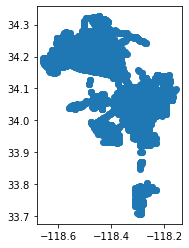

In [43]:
#our bus stops from earlier extend outside city boundaries
#join with city shape file to fix this
la_bus = gpd.sjoin(bus, city)
la_bus.plot()

(-118.69379615000001, -118.12964684999997, 33.6719924, 34.3689876)

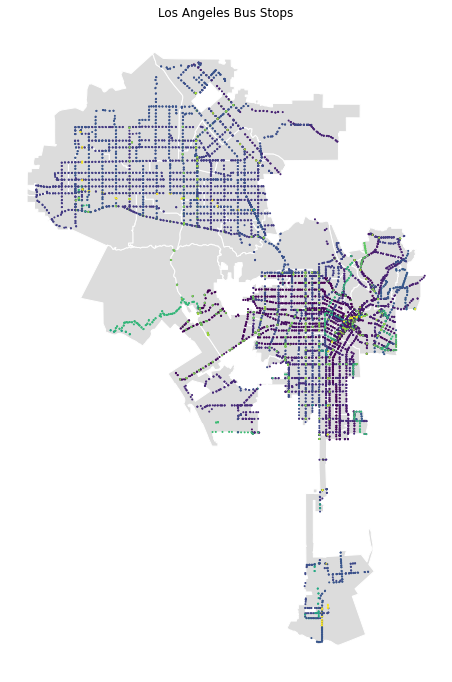

In [44]:
#let's look at bus stops in context
base=city.plot(figsize=(12,12),color='gainsboro', 
                               edgecolor='white')

ax5 = la_bus.plot(ax=base, 
                     column='line',
                     legend=False,
                     markersize=1)

# add a title
ax5.set_title('Los Angeles Bus Stops')

# get rid of the axis
ax5.axis('off')

(-118.69379615000001, -118.12964684999997, 33.6719924, 34.3689876)

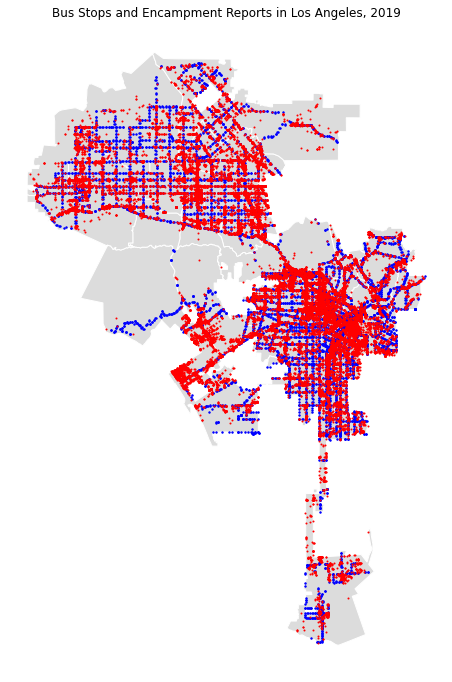

In [45]:
#looking at encampments and transit together, there certainly appears to be correlation
base=city.plot(figsize=(12,12),color='gainsboro', edgecolor='white')
ax0 = la_bus.plot(ax=base, color='blue', markersize=2)
ax = encamp_19.plot(ax=base, color='red', markersize=1)

# add a title
ax.set_title('Bus Stops and Encampment Reports in Los Angeles, 2019')

# get rid of the axis
ax.axis('off')

(-118.69400331345491, -118.12963698507356, 33.6719924, 34.3689876)

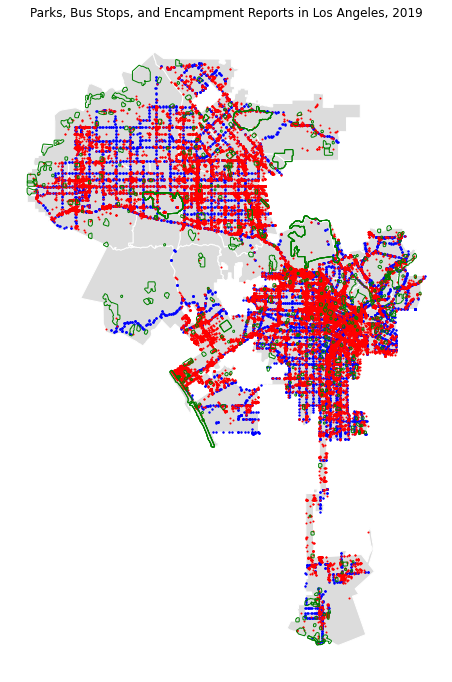

In [46]:
#my next step will be to look at potential service locations by adding transit accessibility
#to the park-encampment dynamic
base=city.plot(figsize=(12,12),color='gainsboro', edgecolor='white')
ax0 = la_bus.plot(ax=base, color='blue', markersize=2)
ax = encamp_19.plot(ax=base, color='red', markersize=1)
ay = park_info.plot(ax=base, color='none', edgecolor='green')

# add a title
ax.set_title('Parks, Bus Stops, and Encampment Reports in Los Angeles, 2019')

# get rid of the axis
ax.axis('off')